In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### SET TO EXTRACTED DATA DIR!

In [4]:
EXTRACTED_DATA_DIR = '/home/kotuzo/DATA_NINJA_COMP/EPIK_Solution/all_data/extracted/'

### Load files + transform for time series analysis

In [5]:
sq_df = pd.read_csv(EXTRACTED_DATA_DIR + 'search_queries_2016_11.csv', parse_dates=['sorting_date'])
categories = pd.read_csv(EXTRACTED_DATA_DIR + 'categories.csv')

In [6]:
sq_df.head()

,sorting_date,phrase,category_id,sessions_count,parent_id,name_pl
0,2016-10-24,NaN,15.0,89049.0,1307,Wynajem
1,2016-10-24,kawalerka,15.0,991.0,1307,Wynajem
2,2016-10-24,mieszkanie,15.0,237.0,1307,Wynajem
3,2016-10-24,warszawa,15.0,215.0,1307,Wynajem
4,2016-10-24,2 pokoje,15.0,203.0,1307,Wynajem


In [7]:
sq_time_series = sq_df.set_index('sorting_date')

In [8]:
sq_time_series.head()

,phrase,category_id,sessions_count,parent_id,name_pl
sorting_date,,,,,
2016-10-24,NaN,15.0,89049.0,1307,Wynajem
2016-10-24,kawalerka,15.0,991.0,1307,Wynajem
2016-10-24,mieszkanie,15.0,237.0,1307,Wynajem
2016-10-24,warszawa,15.0,215.0,1307,Wynajem
2016-10-24,2 pokoje,15.0,203.0,1307,Wynajem


#### Functions for categories

In [9]:
def list_categories(leaf_id, categories):
    parent_id_exists = True
    cat_list = []
    parent_id = 1
    while parent_id > 0:
        name = categories[categories['id'] == leaf_id]['name_pl'].iloc[0]
        parent_id = categories[categories['id'] == leaf_id]['parent_id'].iloc[0]
        ind = categories[categories['id'] == leaf_id]['id'].iloc[0]
        cat_list.append(name)
        leaf_id = parent_id
    return list(reversed(cat_list))

def get_top_parent_category(leaf_id, categories):
    parent_id = 1
    while parent_id > 0:
        parent_id = categories[categories['id'] == leaf_id]['parent_id'].iloc[0]
        p_id = categories[categories['id'] == leaf_id]['id'].iloc[0]
        leaf_id = parent_id
    return p_id

Sanity check

In [10]:
get_top_parent_category(188, categories)

5

In [11]:
def removeTimeFromDateTime(df, columnName):
    return pd.to_datetime(df[columnName])

def get_ts_for_cat(l_id, df):
    temp_df = df[df['category_id'] == l_id]
    return temp_df['sessions_count'].resample('D').sum()

# print(list_categories(l_id, categories))
# print(get_top_parent_category(l_id, categories))

In [12]:
l_id = 188
print(get_ts_for_cat(l_id, sq_time_series))
print(list_categories(l_id, categories))
print(get_top_parent_category(l_id, categories))  # maybe super parent category would be helpful

sorting_date
2016-10-18    28210.0
2016-10-19    28715.0
2016-10-20    29244.0
2016-10-21    29420.0
2016-10-22    30104.0
2016-10-23    37726.0
2016-10-24    29367.0
2016-10-25    29493.0
2016-10-26    28225.0
2016-10-27    27001.0
2016-10-28    26422.0
2016-10-29    27956.0
2016-10-30    39190.0
2016-10-31    28415.0
Freq: D, Name: sessions_count, dtype: float64
['Motoryzacja', 'Samochody osobowe', 'Fiat']
5


Look at some trends

In [13]:
import statsmodels.api as sm

/home/kotuzo/anaconda3/envs/ML_FULL/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
X = np.arange(14)

In [15]:
X = sm.add_constant(X)

In [16]:
temp_ts = get_ts_for_cat(188, sq_time_series)
Y = np.array(list(temp_ts))

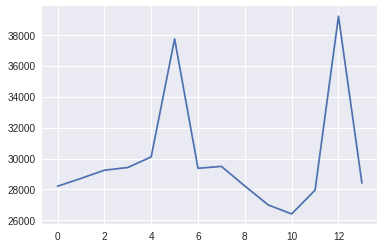

In [17]:
plt.plot(Y)

Try with linear regression - it could be a new feature representing trend

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
model = LinearRegression()

In [20]:
model.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
model.coef_[1]

91.032967032967065

In [22]:
model.intercept_  # it could be a feature also

29371.714285714286

In [23]:
Xs = np.arange(14)

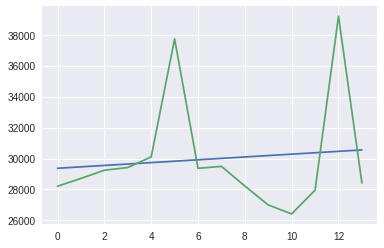

In [24]:
plt.plot(Xs * model.coef_[1] + model.intercept_)
plt.plot(Y)

Hmm... It could work, those peaks are weird, it's quite common in this dataset. Still I don't know what could be a potential cause of such peaks.

In [25]:
Y

array([ 28210.,  28715.,  29244.,  29420.,  30104.,  37726.,  29367.,
        29493.,  28225.,  27001.,  26422.,  27956.,  39190.,  28415.])

Derivateive of linear function is its coeficient f(x) = ax+b => f'(x) = a:

In [26]:
def get_derivative_of_ts(vals):
    lm = LinearRegression()
    X = np.arange(len(vals))
    X = sm.add_constant(X)
    model.fit(X, vals)
    return model.coef_[1]

### Potential features extracted from time series data

In [27]:
get_derivative_of_ts(Y)

91.032967032967065

In [28]:
Y.mean()

29963.428571428572

In [29]:
Y.max()

39190.0

In [30]:
Y.min()

26422.0

In [31]:
Y.std()

3607.503464294658

### Look at ads data

In [32]:
ads_df = pd.read_csv(EXTRACTED_DATA_DIR + 'ads_2016_11.csv', parse_dates=['sorting_date', 'created_at_first', 'valid_to'])

In [33]:
pd.set_option('display.max_columns', 50)
ads_df.head()

,id,region_id,category_id,subregion_id,district_id,city_id,accurate_location,user_id,sorting_date,created_at_first,valid_to,title,description,full_description,has_phone,params,private_business,has_person,photo_sizes,paidads_id_index,paidads_valid_to,predict_sold,predict_replies,predict_views,reply_call,reply_sms,reply_chat,reply_call_intent,reply_chat_intent,parent_id,name_pl
0,471113355,3,279,303,385.0,1721963681,0,2052953831,2016-10-28,2012-07-04 09:18:13,2016-11-27 08:10:47,Ekogroszek workowany Pieklorz <CITY> - POLMARK...,"Ekogroszek Pieklorz chwałowicki - ""Iskierka zi...","Ekogroszek Pieklorz chwałowicki - ""Iskierka zi...",t,price<=>price<br>price<=>940<br>state<=>new,business,t,"{""1"":{""w"":489,""h"":700}}",NaN,NaN,f,0,20,0,0,0,0,0,628,Ogrzewanie
1,1499520116,4,279,102,273.0,239224901,0,1029350709,2016-10-19,2012-07-06 13:20:34,2016-11-18 08:08:58,Piec akumulacyjny dynamiczny 2-5 kw w zestawie...,PROMOCJA !!! do 30.10.16\nElektryczny ogrzewac...,PROMOCJA !!! do 30.10.16\nElektryczny ogrzewac...,t,price<=>price<br>price<=>1599<br>state<=>new,business,t,"{""6"":{""w"":640,""h"":480},""4"":{""w"":933,""h"":700},""...",NaN,NaN,f,0,31,0,0,0,0,0,628,Ogrzewanie
2,102041578,17,279,158,NaN,1757638379,0,1888396760,2016-10-24,2012-07-08 16:36:20,2016-11-23 15:50:09,Drewno kominkowe i opalowe,witam sprzedam drewno kominkowe buk brzoza por...,witam sprzedam drewno kominkowe buk brzoza por...,t,price<=>arranged<br>price<=>160<br>state<=>,business,t,"{""1"":{""w"":600,""h"":450},""2"":{""w"":600,""h"":450},""...",NaN,NaN,f,2,109,2,0,0,8,0,628,Ogrzewanie
3,702118202,6,279,151,NaN,1555929073,0,2004944584,2016-10-22,2012-07-05 13:53:29,2016-11-21 14:41:14,"Ekogroszek, Eko Groszek <CITY> Wesoła - 660 zł...","Skład węgla i opału ""TRANS SYSTEM"" w <CITY> po...","Skład węgla i opału ""TRANS SYSTEM"" w <CITY> po...",t,price<=>price<br>price<=>660<br>state<=>,business,t,"{""1"":{""w"":400,""h"":300}}",NaN,NaN,f,1,27,1,0,0,4,0,628,Ogrzewanie
4,531473873,7,279,18,NaN,2070997215,0,727192699,2016-10-19,2012-07-04 06:39:35,2016-11-18 21:11:23,Ekogroszek Pieklorz Jaret KHW Skarbek workowan...,W ofercie naszej firmy znajduje się bogaty aso...,W ofercie naszej firmy znajduje się bogaty aso...,t,price<=>price<br>price<=>800<br>state<=>new,business,t,"{""2"":{""w"":1000,""h"":531},""1"":{""w"":419,""h"":468}}",NaN,NaN,f,0,27,0,0,0,3,0,628,Ogrzewanie


In [34]:
15 in ads_df['category_id'].unique()  # how is it possible that the most searched category has no corresponding ad?

False

In [35]:
list_categories(15, categories)

['Nieruchomości', 'Mieszkania', 'Wynajem']

In [36]:
print(len(ads_df[ads_df['category_id'] == 15]['predict_sold']))
print(len(ads_df[(ads_df['category_id'] == 15) & (ads_df['predict_sold'] == 't')]['predict_sold']))

0
0


In [37]:
def get_percentage_of_sold(ad_df, category_id):
    all_ads = len(ad_df[ad_df['category_id'] == category_id]['predict_sold'])
    sold_ads = len(ad_df[(ad_df['category_id'] == category_id) & (ad_df['predict_sold'] == 't')]['predict_sold'])
    # print(all_ads)
    return sold_ads / all_ads

In [38]:
list_categories(279, categories)

['Dom i Ogród', 'Ogrzewanie']

In [39]:
print(get_ts_for_cat(628, sq_time_series))
print(get_ts_for_cat(279, sq_time_series))

Series([], Freq: D, Name: sessions_count, dtype: float64)
Series([], Freq: D, Name: sessions_count, dtype: float64)


That's weird... No data for sessions, although it was searched and even sold for some cases.

In [40]:
print(get_top_parent_category(279, categories))

628


In [45]:
sq_df.groupby('category_id')['sessions_count'].sum().idxmax()

15.0

In [47]:
ads_df[ads_df['category_id'] == 15]

,id,region_id,category_id,subregion_id,district_id,city_id,accurate_location,user_id,sorting_date,created_at_first,valid_to,title,description,full_description,has_phone,params,private_business,has_person,photo_sizes,paidads_id_index,paidads_valid_to,predict_sold,predict_replies,predict_views,reply_call,reply_sms,reply_chat,reply_call_intent,reply_chat_intent,parent_id,name_pl


WTF??? No ads for category 15, which is wynajem, and there is 1000000+ search queries for it...

['Nieruchomości', 'Mieszkania', 'Wynajem']
sorting_date
2016-10-18     98242.0
2016-10-19     96587.0
2016-10-20     92633.0
2016-10-21     82239.0
2016-10-22     72333.0
2016-10-23     87693.0
2016-10-24    102138.0
2016-10-25     99688.0
2016-10-26     93095.0
2016-10-27     87956.0
2016-10-28     76075.0
2016-10-29     67874.0
2016-10-30     78767.0
2016-10-31     76493.0
Freq: D, Name: sessions_count, dtype: float64


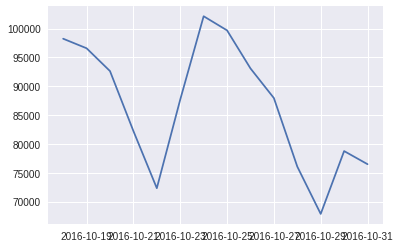

In [48]:
print(list_categories(15, categories))
print(get_ts_for_cat(15, sq_time_series))
plt.plot(get_ts_for_cat(15, sq_time_series))

Let's check how many items they sold from the category

In [49]:
get_percentage_of_sold(ads_df, 180)

0.16740088105726872

We could do such analysis for every category (only the leaves or aggregated, or top parents only) and see how does it look globally

#### The questions (if you can answer, feel free to do so :))

Check the impact of trends on sold attribute

Check the impact of regions on sold attribute

Are there better or worse reputation users? Does it have any impact on sold?

Impact of description. Probably we will be doing later sentiment classification of descriptions

Impact of trends on views and replies

How to check relevancy of prices? Maybe it would be a better idea to train a model using categorical data of price, like normal/too_low/too_high? Is just the price can give to the computer good information?

Is valid_to very important? Like when it's ending before two weeks or after? Does it have some impact?

What about nulls in category_id? Probably need to impute correct category there somehow.